In [1]:
import pickle
import json
import torch
from glob import glob

# data loading

## BERT embedding loading

In [2]:
pt_files = sorted(glob('../bert_file/*.pt'))
pt_files_index = [int(pt.split('_')[-1].split('.')[0]) for pt in pt_files]

In [3]:
for pt in pt_files:
    try:
        torch.load(pt)
    except:
        print(pt)

../bert_file/doc_11926.pt
../bert_file/doc_17742.pt


In [4]:
tensors = [torch.load(pt) for pt in pt_files
          if pt not in ['../bert_file/doc_11926.pt', '../bert_file/doc_17742.pt']]

## Label loading 

In [5]:
with open('../file/train.jsonl') as f:
    data = [json.loads(line) for line in f]

In [6]:
data_sample = [data[index] for index in pt_files_index]

In [7]:
label_sample = [torch.Tensor([1 if _ in data['extractive'] else 0 
                            for _ in range(len(data['article_original']))]) 
                for idx, data in enumerate(data_sample)
               if idx not in [11926, 17742]]

In [8]:
len(label_sample)

19105

## train-valid split 

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_data, test_data, train_y, test_y = train_test_split(tensors, label_sample, test_size=0.1)

In [11]:
len(train_data), len(train_y)

(17194, 17194)

## Dataset 

In [12]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [13]:
class transformerDataset(Dataset):
    def __init__(self, data_x, data_y, transform_x=None, transform_y=None):
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample_x = self.data_x[idx]
        sample_y = self.data_y[idx]
        return sample_x, sample_y

In [14]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)
    return xx_pad, yy_pad

In [15]:
# tensors = collate_fn_padd(tensors)

In [16]:
# tensors.shape

In [17]:
# label_sample

In [18]:
bs = 128

In [19]:
ds = transformerDataset(train_data, train_y)
dl = DataLoader(ds, batch_size=bs, collate_fn=pad_collate, shuffle=True, drop_last=True)

In [20]:
for d in dl:
    if d[0].shape[0] == bs:
        pass
    else:
        print(d[0].shape)

In [21]:
ds_test = transformerDataset(test_data, test_y)
dl_test = DataLoader(ds, batch_size=bs, collate_fn=pad_collate, shuffle=True, drop_last=True)

## model 

In [22]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [23]:
# data_sample

In [24]:
# BERT_EMBEDDING_DIM = 768

In [25]:
# encoder_layer = TransformerEncoderLayer(d_model=BERT_EMBEDDING_DIM, nhead=2, dim_feedforward=128, dropout=0.5)
# transformer_encoder = TransformerEncoder(encoder_layer, num_layers=1)

In [26]:
# tensors[0].shape

In [27]:
# linear = nn.Linear(in_features=768, out_features=1)

In [28]:
# tensors[1].shape

In [29]:
# tensors[0].unsqueeze(0).shape

In [30]:
# trans_output = transformer_encoder(tensors[0].unsqueeze(0))

In [31]:
# trans_output.shape

In [32]:
# output = linear(trans_output)
# sigmoid = nn.Sigmoid()
# output = sigmoid(output)
# output.shape

In [33]:
# target = torch.Tensor(label_sample[0])

In [34]:
# output.shape

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
# output.shape, target.shape

In [37]:
# criterion(output, target.view(1,-1,1))

In [38]:
class PositionalEncoding(nn.Module):
    # positional encoding layer 따로 정의 
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model) # positonal encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수는 cos 함수 적용
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [39]:
class TransformerModel(nn.Module):

    def __init__(self, ninp, nhead, nhid, n_class, dropout=0.5):
        # ntoken : number of sentence
        # ninp : the number of expected features in the input
        # nhead : the number of heads in multi-head attention model 
        # nhid : the dimension of the feedforward network model 
        # nlayers : the number of class
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_class)
        self.ninp = ninp
        self.linear = nn.Linear(in_features=ninp, out_features=n_class)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.layernorm = nn.LayerNorm(ninp)
    def init_weights(self):
        initrange = 0.1
        # encoder의 nn.Embedding의 레이어 초기화
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = src * math.sqrt(self.ninp)
        
        src = self.pos_encoder(src)
        src = self.layernorm(src)
        output = self.transformer_encoder(src)
        output = self.linear(output)
        output = self.softmax(output)
        output = self.dropout(output)
        return output

In [40]:
criterion = nn.BCEWithLogitsLoss()
device = 'cuda'
model = TransformerModel(ninp=768, nhead=64, nhid=4096, n_class=1).to(device)
lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [41]:
def get_test_accuracy(model):
    common = 0
    all_common = 0
    for idx, test_batch in enumerate(dl_test):
        tensor = test_batch[0].to(device)
        label = test_batch[1].to(device)
        label = label.view(bs, -1, 1)
        output = model(tensor)
        argtopk = output.topk(3, axis=1)[1]
        output = label.topk(3, axis=1)[1]
        output = output.view(bs, -1)
        argtopk = argtopk.view(bs, -1)
        for opt, lbl in zip(output, argtopk):
            common += len(set(opt.tolist()).intersection(lbl.tolist()))
            all_common += 3
    return common / all_common

In [42]:
get_test_accuracy(model)

0.18357431592039802

In [43]:
# max(accuracy_list)

In [ ]:
loss_list = []
accuracy_list = []
best_accuracy = 0.5
for epoch in range(300):
    i = 0 
    for batch in dl:
        model.train()
        tensor = batch[0].to(device)
        label = batch[1].to(device)
        try:
            label = label.view(bs, -1, 1)
            output = model(tensor)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            i += 1
            if i % 100 == 0 :
                loss_list.append(loss)
                model.eval()
                accuracy = get_test_accuracy(model)
                print('test accuray : {}'.format(accuracy))
                accuracy_list.append(accuracy)
                if best_accuracy < accuracy:
                    best_model = model
                    best_accuracy = accuracy
        except Exception as e:
            print(e)
            print(tensor.shape, output.shape, label.shape)

test accuray : 0.4587997512437811
test accuray : 0.46204524253731344
test accuray : 0.4617342972636816
test accuray : 0.4592467350746269
test accuray : 0.46148165422885573
test accuray : 0.4623173196517413
test accuray : 0.4662235696517413
test accuray : 0.46828358208955223
test accuray : 0.4636582711442786
test accuray : 0.46122901119402987
test accuray : 0.4621035447761194
test accuray : 0.4634833644278607
test accuray : 0.4599269278606965
test accuray : 0.453125
test accuray : 0.45621501865671643
test accuray : 0.44313588308457713
test accuray : 0.44505985696517414
test accuray : 0.44461287313432835
test accuray : 0.44659514925373134
test accuray : 0.44793610074626866
test accuray : 0.4471198694029851
test accuray : 0.4499961131840796
test accuray : 0.44964629975124376
test accuray : 0.4475279850746269
test accuray : 0.4505791355721393
test accuray : 0.44795553482587064
test accuray : 0.4490049751243781
test accuray : 0.4525614116915423
test accuray : 0.46027674129353235
test accura

In [ ]:
import matplotlib.pyplot as plt

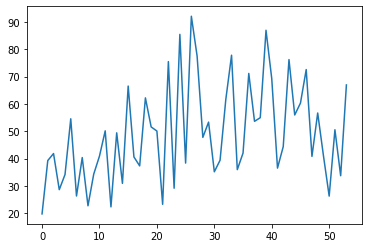

In [97]:
plt.plot(loss_list)

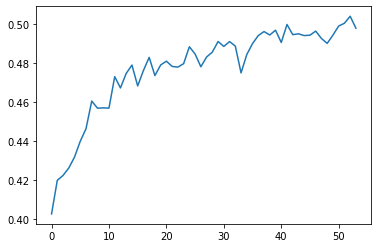

In [98]:
plt.plot(accuracy_list)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import WarmupLinearSchedule
##GPU 사용 시
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()
dataset_train = nlp.data.TSVDataset("/home/sora/Desktop/mkj/tmp/dacon_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("/home/sora/Desktop/mkj/tmp/dacon_test.txt", field_indices=[1,2], num_discard_samples=1)
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=False)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
    def __len__(self):
        return (len(self.labels))
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)
dtype = torch.float
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.num_class = num_classes
        self.hidden_size = 128
        self.final_lstm = nn.LSTM(input_size = hidden_size, hidden_size = self.hidden_size, num_layers=2, bidirectional=True)  # hidden_size * 2 -> *3
        self.logits_fc = nn.Linear(self.hidden_size*2, num_classes)
        self.dropout = nn.Dropout(self.dr_rate)
        self.Softmax = nn.Softmax(dim=1)
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()
    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        all_encoder_layers, pooled = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))        # print(all_encoder_layers.shape)
        lstm_output, states = self.final_lstm(all_encoder_layers)
        lstm_output = lstm_output[-1]
        output = self.logits_fc(lstm_output)
        out = self.dropout(output)
        return out
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)
test_model = BERTClassifier(bertmodel, dr_rate = 1.0).to(device)
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
print(t_total, warmup_step)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_step, t_total=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        if len(label) != batch_size:
            break
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        predictions= model(token_ids, valid_length, segment_ids).squeeze(1)
        loss = loss_fn(predictions, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(predictions, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            torch.save(model.state_dict(), 'model.ckpt')
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = test_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
# torch.save(model, '/home/sora/Desktop/mkj/tmp')